# How do bacterial strains deposited in NCBI change over time? 

In [1]:
#imports 
#%reset
import pandas
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as scipy
from st_helper_functions import *

In [2]:
my_file = "prokaryotes.txt" #hardcoded- bad! 
# reading in initial data set:
data_frame = pandas.read_csv(my_file, sep = '\t', header = 'infer', 
                             low_memory = False)

#stolen from Beth. Should make data imports etc into some functions. 
#How would we write tests for that? 
data_frame['Release Date'] = pandas.to_datetime(data_frame['Release Date'])

#set index
data_frame.index = data_frame['Release Date']
  
df = group_df_by(data_frame, "TaxID")


## What strains are most popular each year? 

In [3]:
df.resample('Y').sum().idxmax(axis=1)

Release Date
1995-12-31      71421
1996-12-31     272634
1997-12-31      85962
1998-12-31     243232
1999-12-31      85963
2000-12-31      64091
2001-12-31        882
2002-12-31      36870
2003-12-31      59919
2004-12-31     279010
2005-12-31       1140
2006-12-31      56780
2007-12-31     419947
2008-12-31        340
2009-12-31       1405
2010-12-31     443255
2011-12-31     796937
2012-12-31    1074919
2013-12-31       1639
2014-12-31        562
2015-12-31       1313
2016-12-31       1313
2017-12-31        562
2018-12-31        562
Freq: A-DEC, dtype: int64

## What is the distribution of species over time? 

The plot is very spiky- some plots have many more deposits than others. I wonder why? 

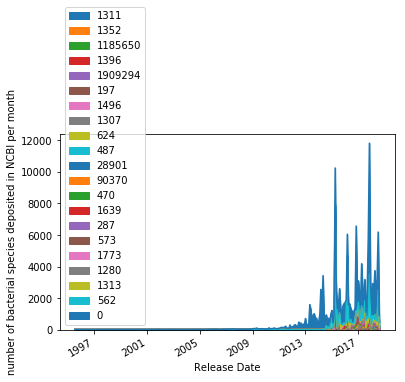

In [4]:
col_order = df.sum().sort_values(inplace=False).index
df1=np.split(df[col_order], [-20], axis=1)

#Combines these dataframes, summing all small values to combine them
final_df = pandas.concat([df1[1], df1[0].sum(axis=1)], axis=1)

#Make the plot! 
final_df.plot.area()
plt.ylabel("number of bacterial species deposited in NCBI per month")
plt.show()


This is the same thing, but cumulative distribution. 

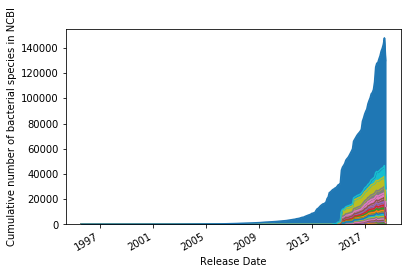

In [5]:
final_df.cumsum().plot.area(legend=False)
plt.ylabel("Cumulative number of bacterial species in NCBI")
plt.show()

## Why are there big spikes? 

Beth suggested the spikes in the data were caused by large institutes unloading all their data to NCBI at once. 

If this is true, we would expect entries in the spikes to be dominated by one Center. Which does appear to be the case (see violin plot below). 

This analysis is really crude, though: I just took really big peaks (>6000 entries). This misses some early peaks. 

In [6]:
#get index of spikes. 
#this is very crude: just take all the big ones. 
#How would I get it responsive to actual 
spikes = final_df.sum(axis=1)[final_df.sum(axis=1) > 6000].index
Center_df = group_df_by(data_frame, "Center")

In [7]:
#new box because group_df_by is so slow 
spike_df = Center_df.loc[spikes]

#remove one-entry months, as they will screw with values. 
Center_df = Center_df[Center_df.sum(axis=1) > 1]

non_spike_df = Center_df.drop(spikes)
spike_proportion = spike_df.max(axis=1)/spike_df.sum(axis=1)
spike_proportion = spike_proportion.tolist()
non_spike_proportion = non_spike_df.max(axis=1)/non_spike_df.sum(axis=1)
non_spike_proportion = non_spike_proportion.tolist()

0.022107464727688618

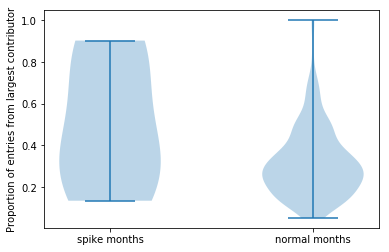

In [8]:
non_spike_df.max(axis=1)/non_spike_df.sum(axis=1)

twosample_results = scipy.stats.ttest_ind(spike_proportion, non_spike_proportion)

matrix_twosample = [
    ['', 'Test Statistic', 'p-value'],
    ['Sample Data', twosample_results[0], twosample_results[1]]
]
matrix_twosample

data = [spike_proportion, non_spike_proportion]
pos = [1, 2]

plt.figure()
ax = plt.subplot(111)
plt.violinplot(data)
ax.set_xticks(pos)
ax.set_xticklabels(["spike months", "normal months"]); #semicolon suppresses chatty matplotlib
plt.ylabel("Proportion of entries from largest contributor");

matrix_twosample[1][2]


We would also expect so see a correlation between number of entries (corrected for time?) and proportion of entries from one Center. 

This does seem to be the case, but the really small entries are throwing out the data a bit. 

I'm also still not correcting for the increase in deposition over time. 

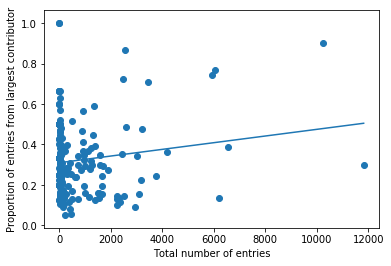

In [9]:
proportion_of_centers = Center_df.max(axis=1)/Center_df.sum(axis=1)

total_entries = Center_df.sum(axis=1)

plt.scatter(total_entries, proportion_of_centers)
plt.plot(np.unique(total_entries), #https://stackoverflow.com/questions/19068862/how-to-overplot-a-line-on-a-scatter-plot-in-python/19069001#19069001
         np.poly1d(np.polyfit(total_entries, proportion_of_centers, 1))(np.unique(total_entries)))
plt.xlabel("Total number of entries")
plt.ylabel("Proportion of entries from largest contributor");

## Correcting for increasing entries with time

If we correct for the total number of entries, by calculating a rolling average, and looking at how the data points compare to that, we get a consistently positive relationship. 

I'm not sure how to choose the rolling average index. Three zeems legit? The data looks a little odd in the larger values, so I'm wary. 

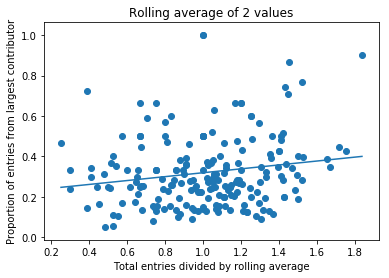

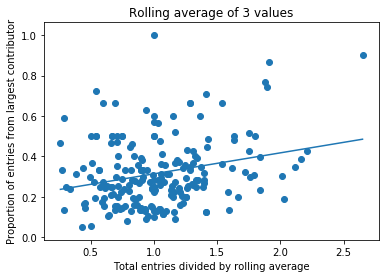

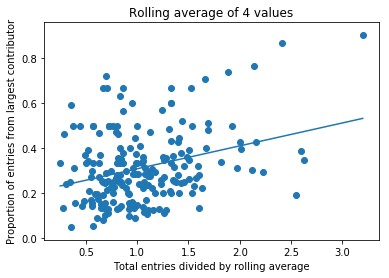

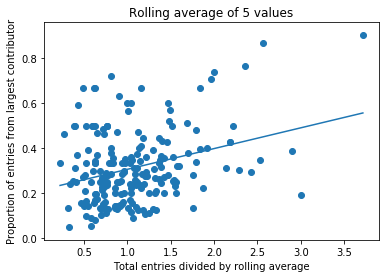

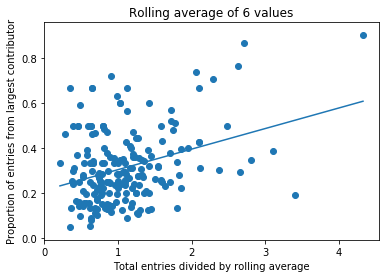

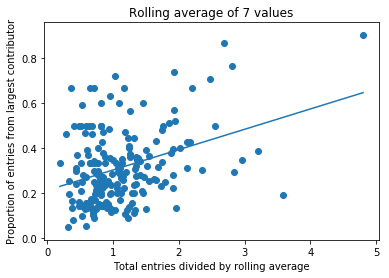

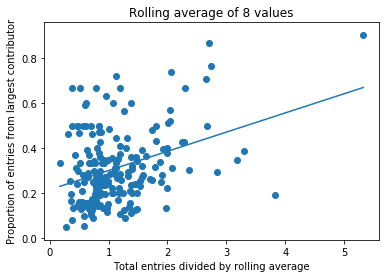

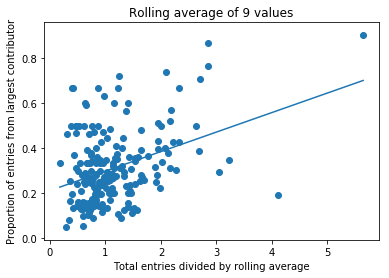

In [10]:
for i in range(2, 10): 
    total_entries_rolling = total_entries.rolling(i).mean()
    proportion = total_entries/total_entries_rolling
    df = pandas.concat([proportion, proportion_of_centers], 
                       axis = 1, 
                       keys = ["proportion", "proportion_of_centers"]).dropna()
    plt.scatter(df.proportion, df.proportion_of_centers)
    plt.xlabel("Total entries divided by rolling average")
    plt.ylabel("Proportion of entries from largest contributor")
    plt.plot(np.unique(df.proportion), #https://stackoverflow.com/questions/19068862/how-to-overplot-a-line-on-a-scatter-plot-in-python/19069001#19069001
         np.poly1d(np.polyfit(df.proportion, df.proportion_of_centers, 1))(np.unique(df.proportion)))
    title = "Rolling average of " + str(i) + " values"
    plt.title(title)
    #print (proportion)
    plt.show()
    
    

## What does this tell us? 

1) In some months, there are a *lot* more bacterial species being deposited into NCBI than others. 
- this appears to be big depositors adding lots of data

2) Most bacterial species being sequenced are not "the big 20". 
- What is driving the increase in NCBI submissions? Model or non-model species? 

## To-Do

- make the code nicer- It'd be nice to be able to make different plots of different variables, without having to re-group the data frame each time. This must be possible. 
- axes etc for the plots! 
- stats
- more sensible analysis of who is depositing 

In [11]:
data_frame


#Organism/Name    TaxID  \
Release Date                                                               
2001-11-07    Salmonella enterica subsp. enterica serovar Ty...   220341   
2006-02-13        Staphylococcus aureus subsp. aureus NCTC 8325    93061   
2001-09-27    Campylobacter jejuni subsp. jejuni NCTC 11168 ...   192222   
2011-12-09                         Pseudomonas fluorescens F113  1114970   
2001-11-08                         Listeria monocytogenes EGD-e   169963   
2001-09-07                     Mycobacterium tuberculosis H37Rv    83332   
2008-12-16                               Escherichia coli IAI39   585057   
2001-10-03                          Streptococcus pneumoniae R6   171101   
2002-12-20                Staphylococcus epidermidis ATCC 12228   176280   
2003-04-16                           Bacillus cereus ATCC 14579   226900   
2001-10-15                                 Yersinia pestis CO92   214092   
2001-01-09              Lactococcus lactis subsp. lactis Il1403   272623   
2001-11-28    Xanthomonas campestris pv. campestris str. ATC...   190485   
2006-07-25                   Clostridium perfringens ATCC 13124   195103   
1995-07-25                       Haemophilus influenzae Rd KW20    71421   
2000-02-25                          Neisseria meningitidis MC58   122586   
1997-08-06                            Helicobacter pylori 26695    85962   
2001-12-27     Mycobacterium avium subsp. paratuberculosis K-10   262316   
2001-01-25                        Mycobacterium bovis AF2122/97   233413   
2003-02-24                       Tropheryma whipplei str. Twist   203267   
2007-02-23    Actinobacillus pleuropneumoniae serovar 5b str...   416269   
2003-07-25    Prochlorococcus marinus subsp. marinus str. CC...   167539   
2001-04-10                        Streptococcus pyogenes M1 GAS   160490   
2002-10-21        Leptospira interrogans serovar Lai str. 56601   189518   
2014-12-10                                   Pseudomonas putida      303   
2000-06-02                              Xylella fastidiosa 9a5c   160492   
2009-01-27                        Agrobacterium radiobacter K84   311403   
2002-05-16                         Bacillus anthracis str. Ames   198094   
2002-10-16                        Shigella flexneri 2a str. 301   198214   
2002-02-13    Fusobacterium nucleatum subsp. nucleatum ATCC ...   190304   
...                                                         ...      ...   
2017-10-10                                     Escherichia coli      562   
2018-03-06                                     Escherichia coli      562   
2018-03-19                                     Escherichia coli      562   
2018-05-01                                     Escherichia coli      562   
2018-05-01                                     Escherichia coli      562   
2018-05-01                                     Escherichia coli      562   
2018-05-02                                     Escherichia coli      562   
2018-05-23                                     Escherichia coli      562   
2016-12-02                                     Escherichia coli      562   
2016-12-02                                     Escherichia coli      562   
2016-12-08                                     Escherichia coli      562   
2016-12-09                                     Escherichia coli      562   
2017-02-17                                     Escherichia coli      562   
2017-02-17                                     Escherichia coli      562   
2017-09-07                                     Escherichia coli      562   
2017-09-06                                     Escherichia coli      562   
2016-10-12                                     Escherichia coli      562   
2014-11-13                                     Escherichia coli      562   
2014-11-13                                     Escherichia coli      562   
2014-11-13                                     Escherichia coli      562   
2014-11-13           

In [12]:
my_file = "prokaryotes.txt" #hardcoded- bad! 
# reading in initial data set:
data_frame = pandas.read_csv(my_file, sep = '\t', header = 'infer', 
                             low_memory = False)

#stolen from Beth. Should make data imports etc into some functions. 
#How would we write tests for that? 
data_frame['Release Date'] = pandas.to_datetime(data_frame['Release Date'])

#set index
data_frame.index = data_frame['Release Date']